In [1]:
from fastai.text.all import *
from pathlib import Path
import random
seed = 1
np.random.default_rng(seed)

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [2]:
# use kwargs??
def get_oversampled_dls(data_path, seed=1, noise_limit=0.15, text_vocab=None):
    df = pd.read_csv(data_path)
    
    dls = TextDataLoaders.from_df(df, text_col='line_text', label_col='speaker', valid_pct=0.1, shuffle=True, seed=seed, text_vocab=text_vocab)
    
    df_train = dls.train.items
    max_dialog = df_train['speaker'].value_counts().max()

    dfs_oversampled = [df_train]
    for _, group in df_train.groupby('speaker'):
        rand_mult = random.uniform(1.0-noise_limit, 1.0 + noise_limit)
        sample_amt_to_max = max_dialog - len(group)
        dfs_oversampled.append(group.sample(int(sample_amt_to_max * rand_mult), replace=True))
        
    dls.train.items = pd.concat(dfs_oversampled)
    return dls

<Axes: >

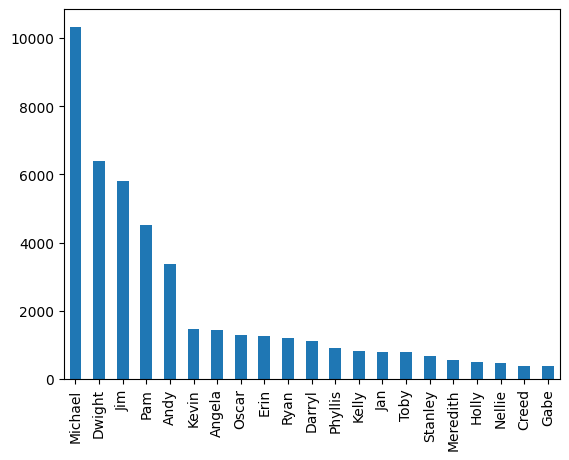

In [3]:
data_path = Path('../data/train21_shuffled.csv')
df = pd.read_csv(data_path)

df['speaker'].value_counts().plot(kind='bar')


In [4]:
dls_lm = TextDataLoaders.from_df(df, text_col='line_text', is_lm=True, valid_pct=0.1, shuffle=True, seed=seed)

In [5]:
dls_lm.show_batch()

,text,text_
0,"xxbos xxmaj yes , i am taking xxmaj andy hunting after work . xxmaj not long ago we were sexual xxunk . i used to hate him , hate him , hate him , hate him . i studied him , to figure out why i hated him so much . xxmaj but that xxunk into a very real friendship , as these things often do . xxbos xxmaj that really works","xxmaj yes , i am taking xxmaj andy hunting after work . xxmaj not long ago we were sexual xxunk . i used to hate him , hate him , hate him , hate him . i studied him , to figure out why i hated him so much . xxmaj but that xxunk into a very real friendship , as these things often do . xxbos xxmaj that really works ."
1,"best time . xxmaj and you know what ? xxmaj now it 's over . xxmaj back to work everyone . xxmaj you too xxmaj andy . xxbos xxmaj ah , so when did you set up shop ? xxbos [ gabe is still standing in front of xxmaj michael 's desk ] xxmaj and you , why are you still here . xxbos xxmaj xxunk , it was n't the way","time . xxmaj and you know what ? xxmaj now it 's over . xxmaj back to work everyone . xxmaj you too xxmaj andy . xxbos xxmaj ah , so when did you set up shop ? xxbos [ gabe is still standing in front of xxmaj michael 's desk ] xxmaj and you , why are you still here . xxbos xxmaj xxunk , it was n't the way he"
2,"on the shoulder as he 's walking by her ] xxmaj see you next xxmaj christmas . xxbos xxmaj what do you think is on it ? xxbos i do n't know any of those . xxbos xxmaj no , xxmaj i 'm not . xxmaj i 'm staying on the bus . xxmaj i 'm already on the bus . xxmaj i 'm going . xxbos xxmaj what are you talking","the shoulder as he 's walking by her ] xxmaj see you next xxmaj christmas . xxbos xxmaj what do you think is on it ? xxbos i do n't know any of those . xxbos xxmaj no , xxmaj i 'm not . xxmaj i 'm staying on the bus . xxmaj i 'm already on the bus . xxmaj i 'm going . xxbos xxmaj what are you talking about"
3,of an idea right now so xxbos xxmaj we 're kind of a dynamic xxunk . xxmaj or xxunk . [ points to xxmaj pam 's tummy ] xxbos xxmaj yes . xxmaj thank you . xxmaj let 's answer that question . xxbos [ laughs ] xxmaj you 're a good kid . xxmaj you know what ? xxmaj it gets bigger once you 're in there . xxmaj enjoy it,an idea right now so xxbos xxmaj we 're kind of a dynamic xxunk . xxmaj or xxunk . [ points to xxmaj pam 's tummy ] xxbos xxmaj yes . xxmaj thank you . xxmaj let 's answer that question . xxbos [ laughs ] xxmaj you 're a good kid . xxmaj you know what ? xxmaj it gets bigger once you 're in there . xxmaj enjoy it .
4,"i mean , what kind of quality of life do we have there ? xxbos xxmaj it 's beautiful . xxbos xxmaj yes you do , xxmaj ryan xxmaj xxunk xxmaj howard . xxmaj you called me stupid . xxbos i xxunk a listening device into the belly of the mallard . xxmaj now i can xxunk xxmaj jim , trap xxmaj jim , and destroy xxmaj jim , just like in","mean , what kind of quality of life do we have there ? xxbos xxmaj it 's beautiful . xxbos xxmaj yes you do , xxmaj ryan xxmaj xxunk xxmaj howard . xxmaj you called me stupid . xxbos i xxunk a listening device into the belly of the mallard . xxmaj now i can xxunk xxmaj jim , trap xxmaj jim , and destroy xxmaj jim , just like in the"
5,"of this smelling like a rose . xxmaj i 've been on my best behavior for nine years . xxmaj if it was n't for the cameras , i would 've done some truly vulgar crap . xxbos xxmaj hey guys , getting psyched for the party ? xxmaj ryan ? xxmaj can i count on you to wear an xxunk xxunk outfit ? xxbos xxmaj alright . xxmaj oscar , got","this smelling like a rose . xxmaj i 've been on my best behavior for nine years . xxmaj if it was n't for the cameras , i would 've done some truly vulgar crap . xxbos xxmaj hey guys , getting psyched for the party ? xxmaj ryan ? xxmaj can i count on you to wear an xxunk xxunk outfit ? xxbos xxmaj alright . xxmaj oscar , got big"
6,"the construction at xxup w.b . xxmaj jones , half of us have to park in the satellite lot . xxbos xxmaj thank you . xx

### From fine tuning, it appears that drop_mult around 0.3, with wd=0.1 or lower is most approapriate for this dataset / language model

In [6]:
data_dir = Path('../data')
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], drop_mult=0.3, wd=0.1, path=data_dir)
learn.fit_one_cycle(8, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.871405,3.501014,0.315494,33.149040,00:26
1,3.434039,3.355489,0.331441,28.659630,00:26
2,3.302881,3.321810,0.334657,27.710468,00:27
3,3.202095,3.308969,0.334190,27.356894,00:27
4,3.127404,3.294722,0.339382,26.969912,00:26
5,3.048661,3.287625,0.339757,26.779196,00:27
6,2.993125,3.285322,0.340468,26.717585,00:26
7,2.959414,3.285556,0.340611,26.723835,00:27


In [7]:
# data_dir = Path('../data')
# scaling_factor=0.2

# for i in range(10):
#     dm = 0.1 + i*scaling_factor
    
#     print(f'Drop mult: {dm}')
#     learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], drop_mult=dm, path=data_dir)
    
#     learn.fit_one_cycle(5, 1e-2)

# data_dir = Path('../data')
# scaling_factor=0.1

# for i in range(9):
#     reg = 0.1 + i*scaling_factor
    
#     print(f'Regularization: {reg}')
#     learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], drop_mult=0.3, wd=reg, path=data_dir)
    
#     learn.fit_one_cycle(5, 1e-2)

In [8]:
encoder_fp = 'tmp_encoder_tst'
learn.save_encoder(encoder_fp)

In [9]:
dls_clas = get_oversampled_dls(data_path, seed=seed, text_vocab=dls_lm.vocab)

<Axes: title={'center': 'Train Distribution'}>

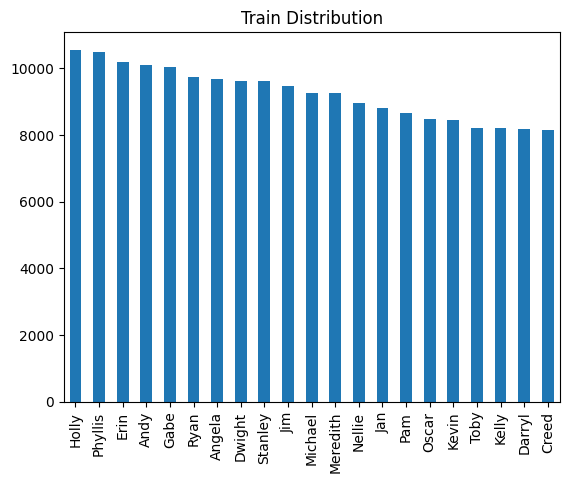

In [10]:
dls_clas.train.items['speaker'].value_counts().plot(kind='bar', title='Train Distribution')

<Axes: title={'center': 'Validation Distribution'}>

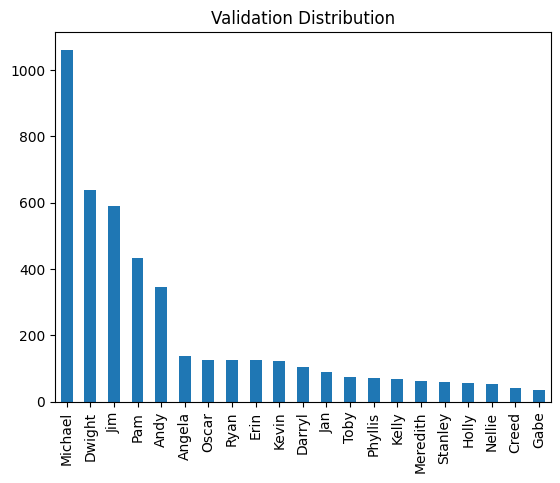

In [11]:
dls_clas.valid.items['speaker'].value_counts().plot(kind='bar', title='Validation Distribution')

In [12]:
dls_clas.show_batch()

,text,category
0,"xxbos xxmaj i 've really learned from the xxunk . xxmaj the great xxunk , xxmaj drew xxmaj xxunk , xxmaj ryan xxmaj xxunk , uh , the xxmaj xxunk guy not so much . xxmaj he 's more the signing , xxmaj wayne xxmaj xxunk . xxmaj um , xxmaj robin xxmaj williams . xxmaj oh , man , would i love to go head - to - head with him . xxmaj oh ! xxmaj that would be exciting . [ as xxmaj robin xxmaj williams ] ' hi . xxmaj i 'm xxmaj xxunk from xxmaj xxunk . ' xxmaj well , xxmaj i 'm xxmaj xxunk from xxmaj xxunk . xxmaj nanoo , nanoo . xxmaj xxunk , xxunk . [ as xxmaj robin xxmaj williams ] ' that 's xxmaj good morning , xxmaj vietnam ! ' xxmaj well , hello to you . xxmaj",Michael
1,"xxbos xxmaj ah , look at me . xxmaj i 'm huge in wilkes - barre . xxmaj performing xxunk , xxmaj michael xxmaj scott . xxmaj not comedy fans here , which is fine because not having a sense of humor is just as fine as having one . xxmaj questions ? xxmaj comment ? xxmaj ca n't see you , but i know that you 're not breathing . i know you 're breathing . xxmaj is this on ? xxmaj hello ? ' well , is n't that … xxmaj well , is n't that special ? ' ' jell - o pudding . ' xxmaj bill xxmaj cosby . i think xxmaj bill xxmaj cosby said it best when he talked about his brother and all of the fun he … xxmaj all the great things they did together as kids . xxmaj and there was",Michael
2,"xxbos i know we have to register as a xxunk sexual relationship with xxup hr . xxmaj my question : do i do it as the man ? xxmaj does she do it as my superior ? i do n't know . xxmaj that leads to other issues that we may have in our relationship . xxmaj it 's , uh , [ phone rings ] xxmaj excuse me . xxmaj hello ? xxmaj hi ! xxmaj just talking about you . xxmaj the camera ? xxmaj no . xxmaj uh huh . xxmaj how 's traffic ? i miss you . xxmaj what . xxmaj ok . xxmaj well , if it was a mistake , it was a wonderful mistake . xxmaj no . [ to camera ] xxmaj would you excuse me ? [ to xxmaj jan ] xxmaj no , i did not xxunk get you",Michael
3,"xxbos [ to the camera ] xxmaj can you get her ? xxmaj she 's right there . [ camera zooms in on xxmaj meredith at here desk ] xxmaj that is xxmaj meredith , the birthday girl . xxmaj and this … is xxmaj meredith 's card . xxmaj happy bird - day . [ laughs ] xxmaj um , let 's see . xxmaj jim , xxmaj jim wrote , ' meredith , i heard you 're turning xxunk , but , come on , you 're an accountant . xxmaj just fudge the numbers . ' xxmaj not bad , pretty funny , i do n't appreciate xxunk corporate fraud though . xxmaj uh , here 's the thing . xxmaj whatever i write here has to be really , really funny . xxmaj because people out there are expecting it . xxmaj i 've already set",Michael
4,"xxbos xxmaj that 's crazy . xxmaj that 's crazy talk ! xxmaj meredith ! xxmaj the xxmaj xxunk , xxunk ' with suppliers ! xxmaj hoo - ooh ! xxmaj wow ! xxmaj what time we got ? [ checks watch ] xxmaj you know what ? xxmaj that 's a good place to end it . xxmaj right there . xxmaj this , i think , was a great ethics seminar . xxmaj she has given us a lot of wonderful things to think about . xxmaj right … what is wrong . xxmaj who 's to say ? xxmaj really . xxmaj in the end . i mean because it is … xxunk . xxmaj but , let 's give her a round of applause . xxmaj holly , everybody . xxmaj holly ! xxmaj get back to work . [ everyone applauds , then leaves ]",Michael
5,"xxbos xxmaj no , not xxmaj harry xxmaj potter . … xxmaj there are no movies in prison . xxmaj this is my point ! xxmaj you guys got it soft , and cushy ! xxmaj this place is freaking awesome ! xxmaj the people are awesome ! xxmaj your boss is nice ! xxmaj everyone seems to get along ! xxmaj people are xxunk ! xxmaj people who … have jumped to xxunk can redeem themselves ! xxmaj nobody is nobody 's bitch . i hope that this scared you . xxmaj and from me , xxmaj prison xxmaj mike , to you , i just wanna thank you for listening to me . xxmaj letting me be a part of your life today . 'cause you got a good life

In [13]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, metrics=accuracy, drop_mult=0.5, path=data_dir)

In [14]:
learn.load_encoder(encoder_fp)

Use discriminative learning and gradual unfreezing to benefit from the LM fine tuning

In [15]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.478391,2.499838,0.250620,00:10


In [16]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.513089,2.462336,0.255578,00:11


In [17]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.443269,2.418790,0.256930,00:16


In [18]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.402121,2.401050,0.270453,00:20
1,2.333467,2.390826,0.278792,00:20


In [19]:
learn.save('ULMFit_test_model')

Path('../data/models/ULMFit_test_model.pth')

In [20]:
learn.fine_tune(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.351223,2.429719,0.270678,00:12


epoch,train_loss,valid_loss,accuracy,time
0,2.357284,2.388829,0.282849,00:20
1,2.378249,2.373971,0.274961,00:19
2,2.270756,2.376346,0.286906,00:20
3,2.123556,2.415519,0.291188,00:19
4,1.948817,2.453851,0.292991,00:20


In [21]:
learn.export('ULMFit_test_export')

### Training beyond this point appears to overfit

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

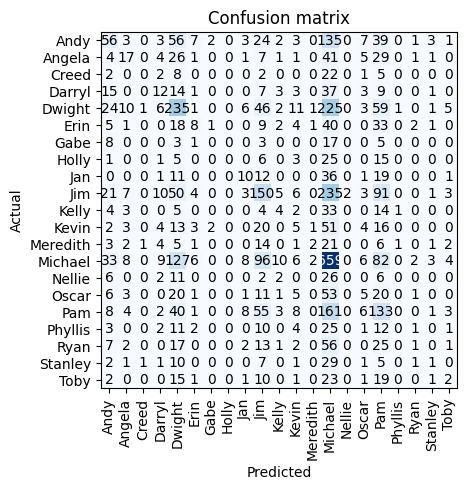

In [23]:
interp.plot_confusion_matrix()

In [24]:
learn.show_results()

,text,category,category_
0,"xxbos xxmaj toby actually gets xxunk from his ex - wife because she makes more , so that 's kind of embarrassing . xxmaj not that xxmaj i 'd mind , but it would never happen to me because i would make the marriage work . xxmaj people seem to like him because they think he 's one of us , but he 's not . xxmaj he 's this weird xxunk who just tells people , ' do n't do this , do n't do that . xxmaj hire this person for this reason . ' i would complain about him , but who would i go to , to complain about xxmaj toby ? xxmaj toby . xxmaj bias . xxmaj and what does he do about that ? xxmaj nothing . xxmaj because he 's xxmaj toby . xxmaj what kind of name is that ? xxmaj",Michael,Michael
1,"xxbos g xxrep 5 o d morning , xxunk - nashua ! xxmaj sales . xxmaj sales is what xxunk us together , today . xxmaj how do we deal with clients who say , ' frankly , my dear , i do n't give a damn … about paper ' and get them to ' show us the money ! ' xxmaj well , we are going to find out today . xxmaj show of hands . xxmaj how many of you are salesmen ? xxmaj let 's see the salesmen . [ some raise their hands ] xxmaj oh , okay . xxmaj well i know what the rest of you are thinking . xxmaj wow , yuck . xxmaj salesmen are the worst ! xxmaj they are awful . xxmaj they are so arrogant . xxmaj they think the whole place xxunk around them . xxmaj handsome",Michael,Michael
2,"xxbos i did n't watch the whole documentary . xxmaj after a few episodes , it was too painful . i kept wanting to scream at xxmaj pam . xxmaj it took me so long to do so many important things . xxmaj it 's just hard to accept that i spent so many years being less happy than i could have been . xxmaj jim was 5 feet from my desk and it took me four years to get to him . xxmaj it 'd be great if people saw this documentary and learned from my mistakes . xxmaj not that xxmaj i 'm a tragic person . xxmaj i 'm really happy now . xxmaj xxunk would xxunk make my heart xxunk if someone out there saw this and she said to herself ' be strong , trust yourself , love yourself . xxmaj xxunk your fears .",Pam,Jim
3,"xxbos xxup ok everybody , listen up . xxmaj thank you for coming . xxmaj before we get started i wanted to say a few words about this deadly disease called rabies . xxmaj and xxmaj i 'd like you to take a look into the face of rabies . [ turns around a picture of xxmaj meredith in the hospital ] xxmaj that should scare you . xxmaj it scares me . xxmaj you people need to xxunk yourselves . xxmaj myth : 3 xxmaj americans every year die from rabies . xxmaj fact : 4 xxmaj americans every year die from rabies . xxmaj how many of you know someone who has been xxunk or affected by rabies ? xxmaj show of hands . xxmaj one , two , three … too many to count . xxmaj it is truly the silent killer . xxmaj no , it",Michael,Dwight
4,"xxbos i understand . xxmaj it 's in a blind spot because xxmaj i 'm trained in several martial arts and one of them , uh , includes , uh , an awareness that the xxunk bring , uh , of anything on all sides of you . xxmaj it could be behind you or whatever . xxmaj this is directly in a blind spot , so xxmaj i 'm trained to respond xxunk to something right above my head . [ new take ] xxmaj this now i have an eye on . xxmaj you see , it 's on my xxunk and if i needed to block it , attack it , stop it somehow . [ does a martial arts move with his hands ] i could come right out . i mean , i know you 're doing your job , but … xxmaj documentary xxmaj",Dwight,Dwight
5,"xxbos xxmaj toby has been leaving radon xxunk everywhere , like he owns the place . xxmaj the first time i threw mine away , i thought it was an ant trap . [ finds radon kit in between his blinds in his office ] xxmaj but i figured xxmaj i 'd rather live with ants than with his creepy little disc . [ throws it away ] xxmaj the second time … i thought it was one of those , you know , those things you turn over and it xxunk . [ finds another radon kit on top of his cabinet ] xxmaj like a

In [25]:
learn.predict('I wanna eat hot dogs on the beach')

('Kevin',
 tensor(11),
 tensor([0.0208, 0.0208, 0.0175, 0.0417, 0.0132, 0.1279, 0.0011, 0.0032, 0.0004,
         0.0066, 0.0378, 0.2543, 0.2218, 0.0205, 0.0005, 0.0134, 0.0734, 0.0835,
         0.0170, 0.0193, 0.0055]))

In [26]:
df_test = pd.read_csv(data_dir/'test21_shuffled.csv')

,season,episode,scene,line_text,speaker,deleted
0,3,16,29,"Don't hurt that bat, Creed! It's a living thing with feelings and a family!",Kelly,False
1,7,7,27,"I cancelled my plans to come to this thing, and they repay me with this?",Kevin,False
2,8,13,25,"Oh, yes. Oh, what a beautiful child. Prominent forehead, short arms, tiny nose. You will lead millions... [whispers] willingly, or as slaves.",Dwight,False
3,2,17,18,Brad Pitt. Also there will be no bonuses.,Dwight,False
4,5,4,32,"Okay, alright. Hey, you know what? I would appreciate it if people would stop storming off the stage.",Michael,False
...,...,...,...,...,...,...
7827,9,7,32,Yeah.,Pam,False
7828,4,3,25,Alright. Well fight it out amongst yourselves. I was thinking Pammy but boys night out is also good.,Michael,False
7829,7,8,19,Rachel.,Kelly,False
7830,8,21,19,[chuckling] Okay.,Andy,False


In [27]:
dls_test = TextDataLoaders.from_df(df_test, label_col='speaker', text_col='line_text', shuffled=False, vocab=learn.dls.vocab)

In [28]:
preds = learn.get_preds(dl=dls_test.train)
accuracy(preds[0], preds[1])

TensorBase(0.1969)

In [29]:
preds = learn.get_preds(dl=dls_test.valid)
accuracy(preds[0], preds[1])

TensorBase(0.1980)

In [30]:
mask = (df_test['line_text'].str.count(' ') > 4)
df_filtered = df_test[df_test['line_text'].str.count(' ') >= 4]
df_filtered.reset_index()

,index,season,episode,scene,line_text,speaker,deleted
0,0,3,16,29,"Don't hurt that bat, Creed! It's a living thing with feelings and a family!",Kelly,False
1,1,7,7,27,"I cancelled my plans to come to this thing, and they repay me with this?",Kevin,False
2,2,8,13,25,"Oh, yes. Oh, what a beautiful child. Prominent forehead, short arms, tiny nose. You will lead millions... [whispers] willingly, or as slaves.",Dwight,False
3,3,2,17,18,Brad Pitt. Also there will be no bonuses.,Dwight,False
4,4,5,4,32,"Okay, alright. Hey, you know what? I would appreciate it if people would stop storming off the stage.",Michael,False
...,...,...,...,...,...,...,...
5229,7823,2,14,14,[barely stifling laughter] It wasn't me. Um... it wasn't me. [regaining composure] It was not me.,Ryan,False
5230,7824,4,1,18,I wouldn't put it past her.,Angela,False
5231,7825,2,5,34,"Okay, well... I already picked you. And you know that. So, unless I just go through with this, you're always gonna look at me as the guy who almost fired you.",Michael,False
5232,7826,9,19,33,Oof. Always hurts to hear that one.,Meredith,False


In [31]:
dls_test = TextDataLoaders.from_df(df_filtered, text_col='line_text', label_col='speaker', shuffled=False, vocab=learn.dls.vocab)

In [32]:
preds = learn.get_preds(dl=dls_test.train)
accuracy(preds[0], preds[1])

TensorBase(0.2135)

In [33]:
preds = learn.get_preds(dl=dls_test.valid)
accuracy(preds[0], preds[1])

TensorBase(0.1883)